# Problem Set 2: Classical emulation of quantum algorithms

Due on Tuesday, 06.05.2025

## Problem outline

In this problem set you will build a brute force classical simulator for quantum circuits. This of course has an exponential scaling but if we exploit the sparsity of the matrix representation of single and two qubit gates, we can get reasonably far with it. The goal is to apply it to simulate the Deutsch-Jozsa algorithm (and potentially other algorithms in future problem sets).

In [1]:
# load some useful modules

# standard numerics and linear algebra libraries
import numpy as np  
import numpy.linalg as LA
import scipy.linalg as sciLA 

# for making plots
import matplotlib.pyplot as plt

# sparse matrix functions
import scipy.sparse as sparse

# for interactive graphics
from ipywidgets import interactive, interact
from ipywidgets import FloatSlider

# avoid typing np.XY all the time
from numpy import (array, pi, cos, sin, ones, size, sqrt, real, mod, append, arange, exp, kron)

# for making Bloch sphere plots
from qutip import Bloch

# The black box function. Is it constant or balanced??
from black_box import black_box

%matplotlib inline

### Problem 1: Single qubit gates

We start by implementing common single-qubit gates and visualizing their action on the Bloch sphere.

#### (a) Defining the gates

- Define the Pauli gates, and the Hadamard, S and T gates and the identity "gate" (will be useful later) as 2x2 matrices. We recommend to use numpy arrays.
- Define a function that builds a rotation gate rotation(ax, theta) for arbitrary rotation axis ax and angle theta. The function should return the rotation operator as a 2x2 matrix (numpy array). You may find the scipy function `expm()` useful for this. Test your implementation on some cases where you know what should come out (which one should generally do for every line of code one writes ;-).

#### (b) Visualization on the Bloch sphere

In problem set 1, problem 1d, you have shown that if we parameterize a state as $|\psi\rangle =\cos(\theta/2)|0\rangle+e^{i\varphi}\sin(\theta/2)|1\rangle$, where $\theta$ and $\varphi$ are the azimuthal and polar angle defining a point on the surface of the unit sphere in 3D, then the cartesian coordinates of that point correspond to the expectation values of the three Pauli operators.

We now want to visualize single-qubit states and explore the action of different gates in this way. For this, the QuTiP librabry provides the function Bloch(). QuTiP is a very powerful module for numerical simulation of quantum problems (install and explore qutip it you haven't done so yet!).

Use the code below, where a single spin is represented on the Bloch sphere, to familiarize yourself with the Bloch class. (This will only work if the function rotation() is defined and behaves as described in problem 1a). Make sure you understand what the `@ operator` does (dot-product, only available in python 3).

In [ ]:
# initially the spin is in the state |0>
ini = np.array([1,0]) # spin up, north pole
axis = [1,0,0] # rotate about x

#Necessary Matrices
I = np.identity(2)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
H = (1/(2**0.5))*((np.array([[1, 1], [1, -1]], dtype=complex)))
S = np.array([[1, 0], [0, 1j]], dtype=complex)
T = np.array([[1, 0], [0, np.exp(1j*np.pi/4)]], dtype=complex)

# rotate the spin and observe what happens on the Bloch sphere
def rotation(axis, theta):
    axis = np.array(axis, dtype=float)
    norm = np.linalg.norm(axis)
    nx, ny, nz = axis
    pauli = nx * X + ny * Y + nz * Z
    return np.cos(theta/2) * np.eye(2) - 1j * np.sin(theta/2) * pauli # I really tried looking up this expm(), but everytime I got the error telling "No Module Found", so I just manually entered the known formula. 
    

def f(phi):
    # rotate by an angle phi 
    # (using expm for convenience - You could also calculate the component vector after a general rotation analytically)
    state = rotation(axis, phi) @ ini
    # calculate the spin expectation values
    x = np.real(np.vdot(state, X @ state))
    y = np.real(np.vdot(state, Y @ state))
    z = np.real(np.vdot(state, Z @ state))
    print(f"phi = {phi}, coordinates = [{x}, {y}, {z}]")
    
    # plot a point on the sphere
    b = Bloch()
    b.add_points([[x], [y], [z]])
    b.show()
    plt.close()


interact(f, phi=FloatSlider(min=0,max=pi,step=pi/20));

interactive(children=(FloatSlider(value=0.0, description='phi', max=3.141592653589793, step=0.1570796326794896…

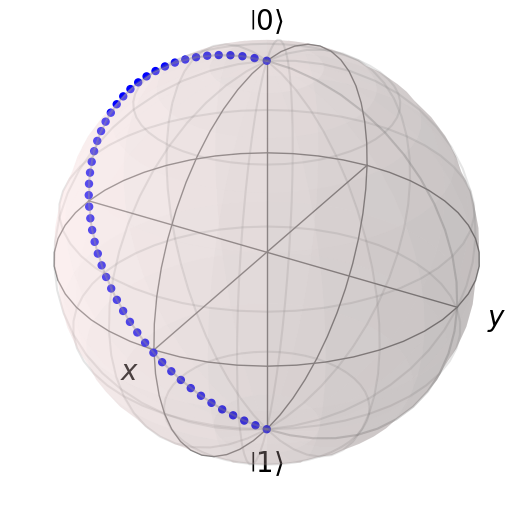

In [11]:
# Alternative without animations
ini = array([1,0]) # spin up, north pole
axis = [1,0,0]
b = Bloch()
npoints=50
max_phi=pi
points = []
# plot the points onto the Bloch sphere
for phi in np.linspace(0,max_phi, npoints):
    state = rotation(axis, phi) @ ini
    x = np.real(np.vdot(state, X @ state))
    y = np.real(np.vdot(state, Y @ state))
    z = np.real(np.vdot(state, Z @ state))
    points.append([x,y,z])

b.add_points(list(zip(*points)))
# color the points such that the gray-level corresponds to the rotation angle
b.point_color=[str(num) for num in np.linspace(0,0.9,npoints)]
# set all markers to have the same style
b.point_marker=['o']
b.point_color = ['b']
b.show()
plt.close()

Now iteratively apply the gate THTH to convince yourself that it indeed is a rotation about an axis $\mathbf{n}^*=(\cos(\pi/8),\sin(\pi/8),\cos(\pi/8))$ (unnormalized), as you have shown on problem set 1 and that the rotation angles densely cover the full circle upon interative application. For this, generate a plot that contains all the states generated from $|0\rangle$ upon apply the gate 100 times.



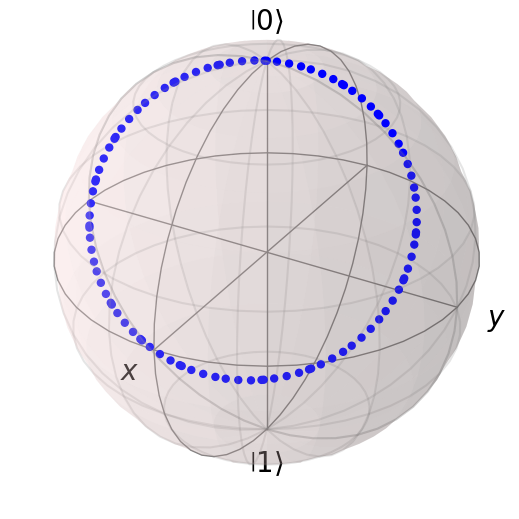

In [12]:
#For THTH Gate,
U = T @ H @ T @ H

state = np.array([1,0], dtype=complex) #Intial_State
states = [state]

for _ in range(100):
    state = U @ state
    states.append(state)

#Bloch_Representation    
b = Bloch()
points = []

for state in states:
    x = np.vdot(state, X @ state).real
    y = np.vdot(state, Y @ state).real
    z = np.vdot(state, Z @ state).real
    points.append([x, y, z])
b.add_points(list(zip(*points)))
b.point_color = ['b']
b.point_marker = ['o']
b.show()
plt.close()

*Optional:*

The action of gates can also be visualized by letting it act on a representative ensemble of states and collectively examine its
effect on them.
Generate a set of sample states, e.g. regularly spaced points on the unit circle in the x-z-plane and apply some of the gates we got to know on Problem Set 1 (H, T, HTH, THTH...) to all of these states. Plot all the points before and after applying the gates jointly on the Bloch sphere to see that what is happening is indeed a rotation about a certain axis. Note: the function `add_points()` of the Bloch class also accepts a list of points. Other potentially useful numpy functions are `linspace()` and `append()`.

### Problem 2: Two qubit gates

Consider a register of two qubits, which take the role of control and target. Show that the CNOT gate can be written as $CNOT = P_0\otimes I + P_1 \otimes X$, where $P_k=|k\rangle\langle k|$ is the projector on the single qubit state $|k\rangle$ and $\otimes$ denotes the tensor product, or Kronecker product (compute the matrix representation of CNOT from this expression).
This way of writing the CNOT gate is instructive as it explicitly distinguishes between the two states of the control qubit. The projectors onto the control qubit states can be read as: If the control qubit is in state $|0\rangle$, do nothing to the taget qubit (apply the identity). If the control qubit is in state $|1\rangle$, flip the taget qubit (apply the X gate). This formulation will also be helpful when we generalize to n-qubit registers. It allows us to implement any controlled unitary gate straight forwardly.

As a first application, we want to execute a quantum circuit that prepares the Bell state $(|00\rangle+|11\rangle)/\sqrt{2}$ (discussed in the lecture):
Initialize the register in state $|00\rangle$, apply a H gate to the first qubit, apply a CNOT gate. Verify by hand that this prepares a Bell state. Implement the preparation numerically: Sequentially apply the gates to the state using the `@` operator. Use the numpy function `kron()` to implement a Hadamard gate on the first qubit (i.e. build the matrix representation of the operator $H\otimes I$) and the CNOT gate (as done above) in this register.

In [13]:
# helper function for generating basis vectors
def basisvec(n, k):
    v = np.zeros(2**n)
    v[k] = 1
    return v

#Construction of CNOT Matrix in the given form
P0 = np.array([[1, 0], [0, 0]])
P1 = np.array([[0, 0], [0, 1]])
CNOT = np.real((np.kron(P0,I) + np.kron(P1,X))) 
print(CNOT, "\n CNOT can be written in the given form above")

psi = basisvec(2,0) 
H1= np.kron(H,I)
psi = H1@psi

psi = CNOT@psi 
print(np.round(psi, decimals=4))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]] 
 CNOT can be written in the given form above
[0.7071+0.j 0.    +0.j 0.    +0.j 0.7071+0.j]


### Problem 3: Building gate operators on an n-qubit register using sparse matrices

We now want to make our gates and registers more general, allowing us to use a register of $n$ qubits and apply single qubit gates to qubit $i$ and entangling gates to qubits $i$ and $j$. For this we will use sparse matrices. If we stored the full matrix representation of our gates, we would store a lot of zeros which would make the code slow.

For a single qubit gate this means we have to build the matrix $\hat{U}^{(i)} = \mathbb{1} \otimes \dots \otimes \mathbb{1} \otimes \hat{U} \otimes \mathbb{1} \otimes \dots \otimes \mathbb{1} = \mathbb{1}_{2^{i}\times 2^{i}} \otimes \hat{U} \otimes \mathbb{1}_{2^{N-i-1}\times 2^{N-i-1}} $, where the subscript represents the size of the matrix. This operation applies the unitary $\hat{U}$ to the $i$th qubit without changing any other qubits.

A function that generates arbitrary single qubit gates is provided for you below. Write a function to gernerate the CNOT gate applied to an arbitrary pair of qubits using a sparse representation of the unitary gate martix representation on the full Hilbert space.

Note that the `buildSparseGateSingle()` function assumes that qubits (and states) are enumerated starting at zero (as is also the python convention for indexing of arrays). That is, the first qubit is $i=0$.

Also note, that when you work with sparse matrices (provided by scipy), you also need to use `kron()` from scipy as well. Numpy's `kron()` does not understand sparse matrices!

Check your implementation by calculating the matrix-representation of a CNOT gate on the first and last qubit in a 3-qubit register and comparing to your expectation.

In [15]:
def buildSparseGateSingle(n, i, gate):
    sgate = sparse.csr_matrix(gate)
    return sparse.kron(sparse.kron(sparse.identity(2**i), sgate), sparse.identity(2**(n-i-1)))

# Now, construct the CNOT
def buildSparseCNOT(n, ctrl, tgt):
    P0_ctrl = np.real(buildSparseGateSingle(n, ctrl, P0))
    P1_ctrl = np.real(buildSparseGateSingle(n, ctrl, P1))
    X_tgt   = np.real(buildSparseGateSingle(n, tgt, X))
    I_full  = np.real(sparse.identity(2**n, format='csr'))

    # CNOT = P0_ctrl ⊗ I + P1_ctrl ⊗ X_tgt
    return P0_ctrl @ I_full + P1_ctrl @ X_tgt

CNOT_3qubit = buildSparseCNOT(3, 0, 2)
print(CNOT_3qubit.toarray())

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


### Problem 4: The Deutsch-Jozsa algorithm

Implement the $U_f$ gate for a general black box (or oracle) function $f: \{0,1\}^n \rightarrow \{0,1\}$. We don't want to simulate the auxiliary qubit explicitly, so the action of the $U_f$ gate is an added phase $(-1)^{f(x)}$ on each basis state x. Let's be super clear on what we mean by this: The computational basis consists of $2^n$ states: $\{|00..0\rangle, |00..01\rangle.., |11..1\rangle  \}$. The bitstring $x$ that enters into the black box function is the binary array of length $n$ that describes the state of each qubit for a given basis state. We can also enumerate  the basis states with the integer numbers $x$ running from $0$ to $2^n-1$. Now the bitstring $x$ is simply the list of binary digits of the integer number $x$. This identification of the "index" of the basis state with the corresponding "state" of the qubits will also be crucial for the other quantum algorithms like the quantum Fourier transform.

The function `indToState()` provided below will be very helpful for building the $U_f$ gate. Make sure you understand what it does.

In [32]:
# some helper functions

# helper function for initializing all qubits in state zero
def initRegister(n):
    return basisvec(n,0)

def indToState(n, k):
    num = bin(k)[2:].zfill(n)
    return array([int(x) for x in str(num)])

# not necessarily needed:
def stateToInd(state):
    return int("".join(str(x) for x in state),2)

def buildUf(f, n):
    """
    Building the Uf gate for a function f: {0,1}^n -> {0,1}
    as a diagonal sparse matrix of size 2^n x 2^n,
    applying a phase (-1)^{f(x)} to each basis state |x⟩
    """
    dim = 2**n
    data = []
    for k in range(dim):
        x = indToState(n, k)  # bitstring of input x
        phase = (-1)**f(x)
        data.append(phase)
    
    return sparse.diags(data, format='csr')

# Constant function: returns 0 for all inputs
def f_const(x):
    return 0

# Balanced function: returns 0 for half, 1 for half
def f_bal(x):
    return x[0]  # depends on first bit

def hadamardGate():
    return 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])

def deutschJozsa(n, f):
    H = hadamardGate()
    # Initial state |00...0⟩
    psi = initRegister(n)

    # Apply H to all qubits: H^{⊗n}
    Hn = sparse.identity(1, format='csr')
    for _ in range(n):
        Hn = sparse.kron(Hn, sparse.csr_matrix(H))
    psi = Hn @ psi

    # Apply Uf
    Uf = buildUf(f, n)
    psi = Uf @ psi

    # Apply H^{⊗n} again
    psi = Hn @ psi

    return psi

def getProbabilities(psi):
    return np.abs(psi)**2
        

Now implement the Deutsch-Jozsa algorithm and use it to detemine for which $n$ the black box function provided along with this problem set is constant and for which it is balanced!

Check the result "classically" (by just calling the black box function often enough). 

Don't look at the source code of the black box function! This will make the wave function of the universe collapse ;-)

In [ ]:
def check_classically(f,n):
    values = set()
    for k in range(2**n):
        x = indToState(n,k)
        values.add(f(x))
        if len(values)>1:
            print("Function is Balanced for Classical Case")
            return
    print("Function is Constant for Classical Case")
    
n = 20
check_classically(black_box, n)

Function is Constant for Classical Case


### Problem 5: Simulating Measurements

The missing element of our quantum computer simulator is the measurement step. In the case we considered above, the output state was always one of the states of the computational basis, i.e. a "classical state" (and not entangled), but in general we end up with superpositions and the outcome of a measurement is random. This randomness we also want to implement in our quantum computer simulator. To do so, we can calculate the probabilities of all basis states and then randomly choose one of these outcomes according to this distribution. Write a function that takes a state $|\psi\rangle$ (i.e. its coefficient vector in the computational basis) as input and outputs one of the computational basis states as the measurement result. You may find the functions `random.rand` and `cumsum` from numpy helpful. 

Test your function on some example states, for example you could create an equal superposition of all basis states by applying Hadamard gates to all qubits.

Apply an $R_x$ rotation to single qubit initially in state $|0\rangle$ using various angles between 0 and $\pi$ and simulate $z$-basis meaurements. Evaluate the expectation value of $Z$ from these measuremets. For what angle are the statistical fluctuations compared to the exact expextation value the largest? 

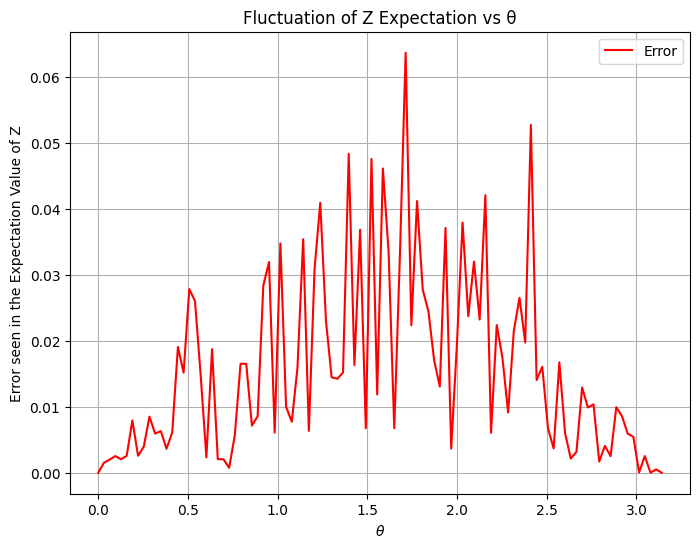

Theta: 0.00 -> Simulated Expectation Value: 1.0000, Exact: 1.0000
Theta: 0.52 -> Simulated Expectation Value: 0.9980, Exact: 0.9995
Theta: 0.79 -> Simulated Expectation Value: 0.9960, Exact: 0.9980
Theta: 1.05 -> Simulated Expectation Value: 0.9980, Exact: 0.9955
Theta: 1.57 -> Simulated Expectation Value: 0.9940, Exact: 0.9920
Theta: 3.14 -> Simulated Expectation Value: 0.9900, Exact: 0.9874


In [50]:
def measure(psi):
    probs = np.abs(psi)**2
    cumulative = np.cumsum(probs)
    r = np.random.rand()
    for idx, prob in enumerate(cumulative):
        if r < prob:
            return idx

def Rx(theta):
    return np.cos(theta/2) * np.identity(2) - 1j * np.sin(theta/2) * np.array([[0, 1], [1, 0]])

def simulate_measurements(theta, shots=1000):
    psi = Rx(theta) @ ini
    results = []
    
    for _ in range(shots):
        outcome = measure(psi)
        z_value = 1 if outcome == 0 else -1
        results.append(z_value)
    avg_z = np.mean(results)
    return avg_z

angles = np.linspace(0, np.pi, 100)
errors = []
simulated_values = []
exact_values = []

for theta in angles:
    exp_sim = simulate_measurements(theta, shots=1000)
    simulated_values.append(exp_sim)
    exp_exact = np.cos(theta)
    exact_values.append(exp_exact)
    errors.append(abs(exp_sim - exp_exact))
    
plt.figure(figsize=(8,6))
plt.plot(angles,errors, label='Error', color='red')
plt.xlabel(r'$\theta$')
plt.ylabel('Error seen in the Expectation Value of Z')
plt.title('Fluctuation of Z Expectation vs θ')
plt.grid(True)
plt.legend()
plt.show()

for i, theta in enumerate([0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, np.pi]):
    print(f"Theta: {theta:.2f} -> Simulated Expectation Value: {simulated_values[i]:.4f}, Exact: {exact_values[i]:.4f}")